In [1]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import statistics
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.optimizers import RMSprop
from keras.layers.normalization import BatchNormalization
from sklearn.metrics import r2_score, mean_squared_error

from numpy.random import seed
seed(1)
import tensorflow as tf
#tf.random.set_seed(1)

Using TensorFlow backend.


In [2]:
# Function to create data with timesteps

def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)):
		end_ix = i + n_steps
		if end_ix > len(data):
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix-1, -1]  #last column is the target variable
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)

In [3]:
# Load the data

data = loadmat('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/data/p5268_ML_Master.mat')

m_t = pd.DataFrame({'Time':data['Time'].ravel().round(2), 'SS':data['SS'].ravel()})    # TTF and TSF not used
a_t = pd.DataFrame({'Time':data['LocalAcTime'].ravel().round(2), 'A_filt':data['A_filt'].ravel(), 'V_filt':data['V_filt'].ravel(),
                    'T_pc':data['T_pc'].ravel(), 'Vel_pc':data['Vel_pc'].ravel(), 'T_der':data['T_der'].ravel(), 'Vel_der':data['Vel_der'].ravel()})
                   # 'T_off':data['T_off'].ravel(), 'Vel_off':data['Vel_off'].ravel()})    # 8 features

df = a_t.merge(m_t, on='Time')
df = df.drop(['Time'], axis=1)

# Create new derived features
#df['A_2'] = np.sqrt(abs(df['A_filt']));
#df['V_2'] = np.sqrt(abs(df['V_filt']));
#df['V_der_2'] = np.sqrt(abs(df['Vel_der']));
#df = df[['A_filt', 'V_filt', 'T_pc', 'Vel_pc', 'T_der', 'Vel_der', 'V_der_2', 'SS']]

arr = df.to_numpy()
n_steps = 1
n_features = df.shape[1]-1
xdf, ydf = create_timesteps(arr, n_steps)
print('Features shape, X = ', np.shape(xdf))
print('Target shape, Y = ', np.shape(ydf))


Features shape, X =  (134039, 1, 6)
Target shape, Y =  (134039,)


In [4]:
# Reshape features from 2D to 1D

print('Before reshaping:', xdf[0])
n_input = xdf.shape[1]*xdf.shape[2]
xdf = xdf.reshape((xdf.shape[0], n_input))
print('Afterreshaping:', xdf[0])

Before reshaping: [[4552.7      5686.803699    0.          0.          0.          0.      ]]
Afterreshaping: [4552.7      5686.803699    0.          0.          0.          0.      ]


In [5]:
## Split into train-val-test
x_train, x_test, y_train, y_test = train_test_split(xdf, ydf, test_size=0.2, shuffle=False)
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.1, shuffle=False)
print("Training:", np.shape(X_train))
print("Validation:", np.shape(X_val))
print("Testing:", np.shape(x_test))


Training: (96507, 6)
Validation: (10724, 6)
Testing: (26808, 6)


Train on 96507 samples, validate on 10724 samples
Epoch 1/40
96507/96507 [==============================] - 10s 99us/step - loss: 3.2341 - val_loss: 0.0195
Epoch 2/40
96507/96507 [==============================] - 8s 82us/step - loss: 0.0233 - val_loss: 0.0316
Epoch 3/40
96507/96507 [==============================] - 8s 80us/step - loss: 0.0178 - val_loss: 0.0178
Epoch 4/40
96507/96507 [==============================] - 8s 85us/step - loss: 0.0182 - val_loss: 0.0230
Epoch 5/40
96507/96507 [==============================] - 8s 86us/step - loss: 0.6258 - val_loss: 0.0213
Epoch 6/40
96507/96507 [==============================] - 8s 80us/step - loss: 0.0216 - val_loss: 0.0194
Epoch 7/40
96507/96507 [==============================] - 8s 85us/step - loss: 0.0151 - val_loss: 0.0171
Epoch 8/40
96507/96507 [==============================] - 8s 81us/step - loss: 0.0163 - val_loss: 0.0221
Epoch 9/40
96507/96507 [==============================] - 8s 82us/step - loss: 0.0150 - val_loss: 0.0186
Epoc

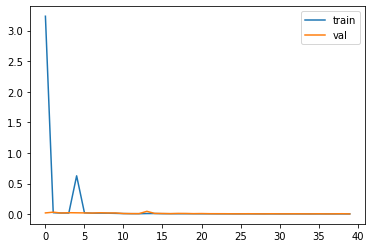

In [6]:
# Build the model

model = Sequential()
model.add(Dense(512, kernel_initializer = 'normal', input_dim = n_input, activation='relu'))
model.add(Dense(256, kernel_initializer = 'normal', activation='relu'))
#model.add(Dropout(0.1))
model.add(Dense(32, kernel_initializer = 'normal', activation='relu'))
#model.add(BatchNormalization())
model.add(Dense(1, kernel_initializer = 'normal', activation='linear'))
model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, Y_train, epochs=40, batch_size=32, validation_data=(X_val, Y_val), verbose=1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [7]:
print(model.summary())
model.save('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/models/MLP1.h5')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               3584      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 143,169
Trainable params: 143,169
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
y_predTrain = model.predict(X_train)
train_r2 = r2_score(Y_train, y_predTrain)
train_rmse = np.sqrt(mean_squared_error(Y_train, y_predTrain))

y_predVal = model.predict(X_val)
val_r2 = r2_score(Y_val, y_predVal)
val_rmse = np.sqrt(mean_squared_error(Y_val, y_predVal))  

y_predTest = model.predict(x_test)
test_r2 = r2_score(y_test, y_predTest)
test_rmse = np.sqrt(mean_squared_error(y_test, y_predTest))

print("R^2 scores: ", train_r2, val_r2, test_r2)
print("RMSE: ", train_rmse, val_rmse, test_rmse)

R^2 scores:  0.8276723133954051 0.8037188456706071 0.6737822496903187
RMSE:  0.04769290266897169 0.059016586989161166 0.0780230865722693


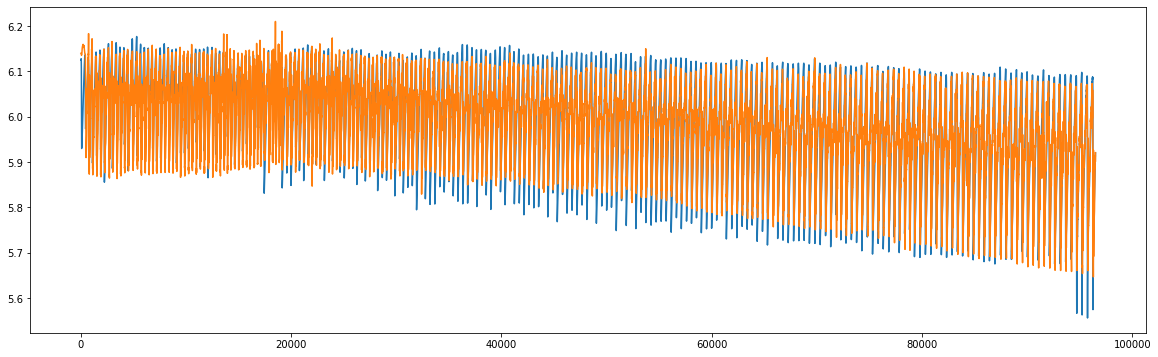

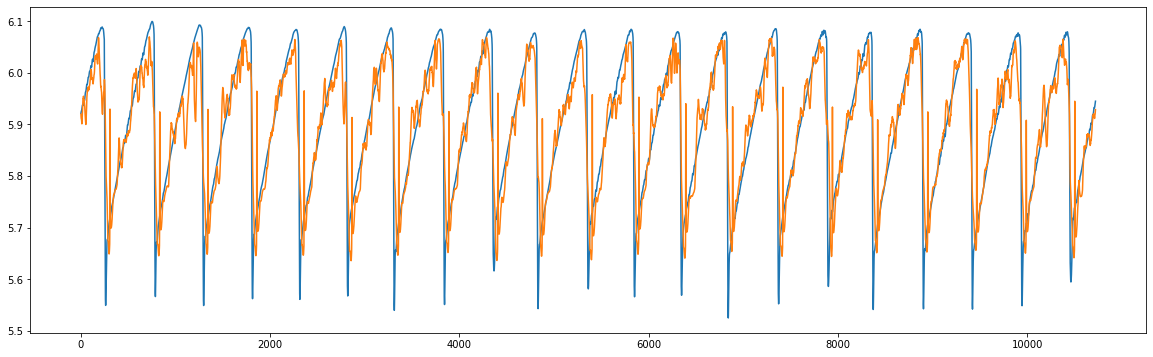

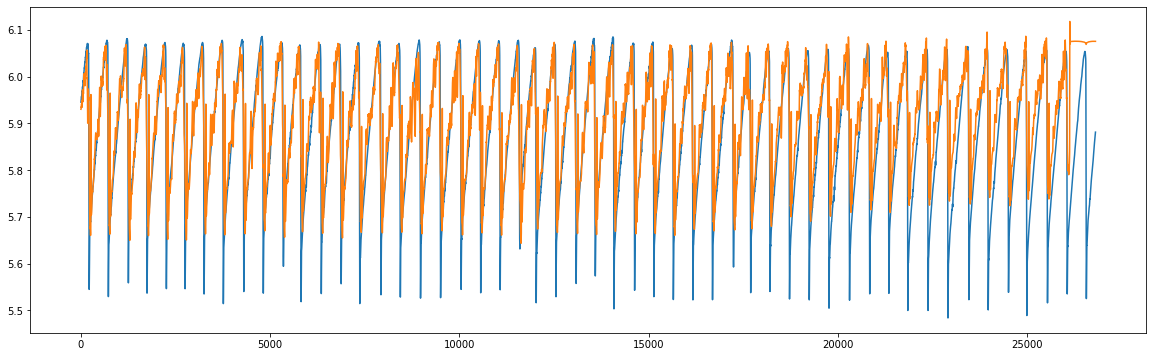

In [9]:
fig = plt.figure(2, figsize=(20,6))
plt.plot(Y_train)
plt.plot(y_predTrain)

fig = plt.figure(3, figsize=(20,6))
plt.plot(Y_val)
plt.plot(y_predVal)

fig = plt.figure(4, figsize=(20,6))
plt.plot(y_test)
plt.plot(y_predTest)


Text(0.5, 1.0, '5000 Samples, Testing Data')

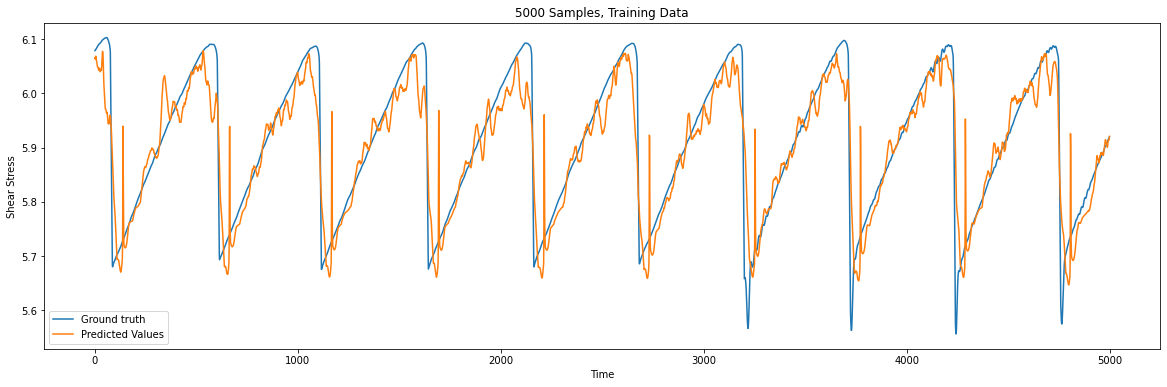

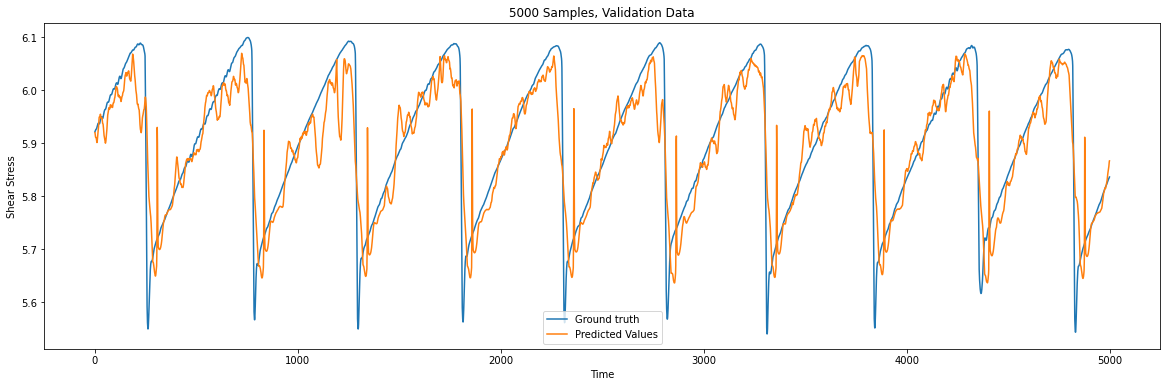

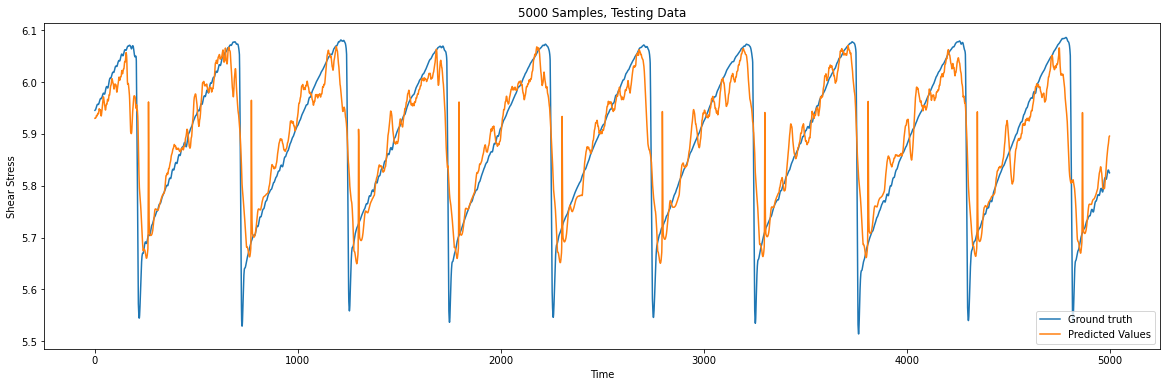

In [10]:
fig = plt.figure(5, figsize=(20,6))
plt.plot(Y_train[-5000:])
plt.plot(y_predTrain[-5000:])
plt.xlabel('Time')
plt.ylabel('Shear Stress')
plt.legend(['Ground truth', 'Predicted Values'])
plt.title('5000 Samples, Training Data')

fig = plt.figure(6, figsize=(20,6))
plt.plot(Y_val[:5000])
plt.plot(y_predVal[:5000])
plt.xlabel('Time')
plt.ylabel('Shear Stress')
plt.legend(['Ground truth', 'Predicted Values'])
plt.title('5000 Samples, Validation Data')

fig = plt.figure(7, figsize=(20,6))
plt.plot(y_test[:5000])
plt.plot(y_predTest[:5000])
plt.xlabel('Time')
plt.ylabel('Shear Stress')
plt.legend(['Ground truth', 'Predicted Values'])
plt.title('5000 Samples, Testing Data')
